In [1]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.model_selection import train_test_split

In [3]:
import wandb

In [4]:
wandb.login(key='6264e29f109d3cf02a9911cd18b6725b79c489cd')

wandb: Currently logged in as: cs22m043. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
wandb.init(name = 'test1', project="Assignment1", entity="cs22m043")
#sweep_id = wandb.sweep(sweep_configuration,entity="cs22m043",project="Assignment1")

In [6]:
np.random.seed(0)

In [7]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

In [9]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [10]:
x_train = x_train.reshape(len(x_train),784)
x_test = x_test.reshape(len(x_test),784)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(54000, 784)
(54000,)
(6000, 784)
(6000,)


In [13]:
enc = OneHotEncoder()
y_OHE_train = enc.fit_transform(np.expand_dims(y_train,1)).toarray()
y_OHE_val = enc.fit_transform(np.expand_dims(y_val,1)).toarray()
y_OHE_test = enc.fit_transform(np.expand_dims(y_test,1)).toarray()
print(y_OHE_train.shape, y_OHE_val.shape, y_OHE_test.shape)

(54000, 10) (6000, 10) (10000, 10)


In [14]:
class FFNNClass:   
    def __init__(self, n_inputs = 784, n_outputs = 10, hidden_sizes=[3], algo='SGD', initialization='xavier', activation='sigmoid', loss='cross_entropy'):
        self.nx = n_inputs
        self.ny = n_outputs
        self.nh = len(hidden_sizes)
        self.sizes = [self.nx] + hidden_sizes + [self.ny] 
        self.algo = algo
        self.params={}
        #self.gradients={}
        self.dW = {}
        self.dB = {}
        self.dH = {}
        self.dA = {}
        self.update_params={}
        self.prev_update_params={}
        self.initialization = initialization
        self.activation = activation
        self.loss = loss
        for i in range(self.nh+1):
            self.update_params["v_w"+str(i+1)]=0
            self.update_params["v_b"+str(i+1)]=0
            self.update_params["m_b"+str(i+1)]=0
            self.update_params["m_w"+str(i+1)]=0
            self.prev_update_params["v_w"+str(i+1)]=0
            self.prev_update_params["v_b"+str(i+1)]=0
            
        if initialization=='xavier':
            for i in range(self.nh+1):
                self.params["W"+str(i+1)]= np.random.randn(self.sizes[i], self.sizes[i+1]) * np.sqrt(1/(self.sizes[i]+self.sizes[i+1]))
                self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
        elif initialization=='random':
            for i in range(self.nh+1):
                self.params["W"+str(i+1)]= np.random.randn(self.sizes[i], self.sizes[i+1]) * 0.01
                self.params["B"+str(i+1)]= np.zeros((1, self.sizes[i+1]))
            
    def sigmoid(self, x):
        #return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
        x = np.clip(x, -500, 500)
        return 1.0/(1.0 + np.exp(-x))
    def grad_sigmoid(self, x):
        return x*(1-x)
    
    def relu(self, x):
        return np.maximum(0,x)
    def grad_relu(self, x):
        return 1*(x>0)
    
    def tanh(self, x):
        return np.tanh(x)
    def grad_tanh(self, x):
        return (1 - (np.tanh(x)**2))

    def softmax(self, x):
        eps = 1e-9
        exps = np.exp(x)
        return exps / (np.sum(exps,axis=1).reshape(-1,1) + eps)

    def forward_pass(self, x, params=None):
        if params is None:
            params=self.params
        self.A = {}
        self.H = {}
        #self.H[0] = x.reshape(1, -1)
        self.H[0] = x  #dimension is 16 * 784
        for i in range(self.nh):
            self.A[i+1] = np.matmul(self.H[i], params["W"+str(i+1)]) + params["B"+str(i+1)]
            if self.activation == 'sigmoid':
                self.H[i+1] = self.sigmoid(self.A[i+1])
            elif self.activation == 'tanh':
                self.H[i+1] = self.tanh(self.A[i+1])
            elif self.activation == 'relu':
                self.H[i+1] = self.relu(self.A[i+1])
        self.A[self.nh+1] = np.matmul(self.H[self.nh], params["W"+str(self.nh+1)]) + params["B"+str(self.nh+1)]
        self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
        return self.H[self.nh+1]

    def predict(self, X):
        Y_pred = self.forward_pass(X)
        return np.array(Y_pred).squeeze()

#     def cross_entropy(self,label,pred):
#         yl = np.multiply(pred,label)
#         yl = yl[yl!=0]
#         yl = -np.log(yl)
#         yl = np.mean(yl)
#         return yl

    def grad(self, x, y, params=None):
        if params is None:
            params=self.params
        self.forward_pass(x,params)
        m = x.shape[0]
        L = self.nh + 1
        if self.loss == 'cross_entropy':
            self.dA[L] = (self.H[L] - y)
        elif self.loss == 'mse':
            self.dA[L] = (self.H[L] - y) * self.H[L] * (1-self.H[L])
        for k in range(L, 0, -1):
            self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
            self.dB[k] = np.sum(self.dA[k],axis=0).reshape(1,-1)
            self.dH[k-1] = np.matmul(self.dA[k], params["W"+str(k)].T)
            if self.activation == 'sigmoid':
                self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
            elif self.activation == 'tanh':
                self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_tanh(self.H[k-1]))
            elif self.activation == 'relu':
                self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_relu(self.H[k-1]))

    def fit(self, X, Y, X_VAL, Y_VAL,  epochs = 5, eta=0.01, display_loss=False, gamma=0.9, eps=1e-8, beta=0.9, beta1=0.9, beta2=0.9, mini_batch_size=1,wt_decay=0.0):

        #if display_loss:
        train_loss = {}
        val_loss = {}
        train_acc = {}
        val_acc = {}
                
        if self.algo == "GD":
            for epoch in range(epochs):
                m = X.shape[0]
                self.grad(X,Y)
                for i in range(self.nh+1):
                    self.params["W"+str(i+1)] -= (eta * (self.dW[i+1]/m) + eta*wt_decay*(self.dW[i+1]/m))
                    self.params["B"+str(i+1)] -= eta * (self.dB[i+1]/m)
                #if display_loss:
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)
                if self.loss == 'cross_entropy':
                    train_loss[epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
                    val_loss[epoch] = log_loss(np.argmax(Y_VAL, axis=1), Y_pred_val)
                elif self.loss == 'mse':
                    train_loss[epoch] = mean_squared_error(Y,Y_pred)
                    train_loss[epoch] = mean_squared_error(Y_VAL,Y_pred_val)
        elif self.algo == "SGD":
            for epoch in range(epochs):
                m = X.shape[0]
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                    for i in range(self.nh+1):
                        self.params["W"+str(i+1)] -= (eta * (self.dW[i+1]/mini_batch_size) + eta*wt_decay*(self.dW[i+1]/mini_batch_size))
                        self.params["B"+str(i+1)] -= eta * (self.dB[i+1]/mini_batch_size)
                #if display_loss:
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)
                if self.loss == 'cross_entropy':
                    train_loss[epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
                    val_loss[epoch] = log_loss(np.argmax(Y_VAL, axis=1), Y_pred_val)
                elif self.loss == 'mse':
                    train_loss[epoch] = mean_squared_error(Y,Y_pred)
                    train_loss[epoch] = mean_squared_error(Y_VAL,Y_pred_val)
                        
        elif self.algo == "Momentum":
            for epoch in range(epochs):
                m = X.shape[0]
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                #self.grad(X, Y)
                    for i in range(self.nh+1):
                        self.update_params["v_w"+str(i+1)] = gamma *self.update_params["v_w"+str(i+1)] + eta * (self.dW[i+1]/mini_batch_size)
                        self.update_params["v_b"+str(i+1)] = gamma *self.update_params["v_b"+str(i+1)] + eta * (self.dB[i+1]/mini_batch_size)
                        self.params["W"+str(i+1)] -= (self.update_params["v_w"+str(i+1)] + eta*wt_decay*(self.dW[i+1]/mini_batch_size))
                        self.params["B"+str(i+1)] -= self.update_params["v_b"+str(i+1)]
                #if display_loss:
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)
                if self.loss == 'cross_entropy':
                    train_loss[epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
                    val_loss[epoch] = log_loss(np.argmax(Y_VAL, axis=1), Y_pred_val)
                elif self.loss == 'mse':
                    train_loss[epoch] = mean_squared_error(Y,Y_pred)
                    train_loss[epoch] = mean_squared_error(Y_VAL,Y_pred_val)
                        
        
        elif self.algo == "RMS_Prop":
            for epoch in range(epochs):
                m = X.shape[0]
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                #self.grad(X, Y)
                    for i in range(self.nh+1):
                        self.update_params["v_w"+str(i+1)] = beta*self.update_params["v_w"+str(i+1)] +(1-beta)*((self.dW[i+1]/mini_batch_size)**2)
                        self.update_params["v_b"+str(i+1)] = beta*self.update_params["v_b"+str(i+1)] +(1-beta)*((self.dB[i+1]/mini_batch_size)**2)
                        self.params["W"+str(i+1)] -= ((eta/(np.sqrt(self.update_params["v_w"+str(i+1)]+eps)))*(self.dW[i+1]/mini_batch_size) + eta*wt_decay*(self.dW[i+1]/mini_batch_size))
                        self.params["B"+str(i+1)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i+1)]+eps)))*(self.dB[i+1]/mini_batch_size)
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)
                if self.loss == 'cross_entropy':
                    train_loss[epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
                    val_loss[epoch] = log_loss(np.argmax(Y_VAL, axis=1), Y_pred_val)
                elif self.loss == 'mse':
                    train_loss[epoch] = mean_squared_error(Y,Y_pred)
                    train_loss[epoch] = mean_squared_error(Y_VAL,Y_pred_val)
                        
        elif self.algo == "NAG":
            for epoch in range(epochs):
                m = X.shape[0]
                temp_params = {}
                
                for k in range(0,m,mini_batch_size):
                    for i in range(self.nh+1):
                        self.update_params["v_w"+str(i+1)]=gamma*self.prev_update_params["v_w"+str(i+1)]
                        self.update_params["v_b"+str(i+1)]=gamma*self.prev_update_params["v_b"+str(i+1)]
                        temp_params["W"+str(i+1)]=self.params["W"+str(i+1)]-self.update_params["v_w"+str(i+1)]
                        temp_params["B"+str(i+1)]=self.params["B"+str(i+1)]-self.update_params["v_b"+str(i+1)]
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size],temp_params)
                    for i in range(self.nh+1):
                        self.update_params["v_w"+str(i+1)] = gamma *self.update_params["v_w"+str(i+1)] + eta * (self.dW[i+1]/mini_batch_size)
                        self.update_params["v_b"+str(i+1)] = gamma *self.update_params["v_b"+str(i+1)] + eta * (self.dB[i+1]/mini_batch_size)
                        self.params["W"+str(i+1)] -= (eta * (self.update_params["v_w"+str(i+1)]) + eta*wt_decay*(self.dW[i+1]/mini_batch_size))
                        self.params["B"+str(i+1)] -= eta * (self.update_params["v_b"+str(i+1)])
                    self.prev_update_params=self.update_params 
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)
                if self.loss == 'cross_entropy':
                    train_loss[epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
                    val_loss[epoch] = log_loss(np.argmax(Y_VAL, axis=1), Y_pred_val)
                elif self.loss == 'mse':
                    train_loss[epoch] = mean_squared_error(Y,Y_pred)
                    train_loss[epoch] = mean_squared_error(Y_VAL,Y_pred_val)
                    
        elif self.algo == "Adam":
            for epoch in range(epochs):
                m = X.shape[0]
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                    num_updates=0
                    for i in range(self.nh+1):
                        num_updates+=1
                        self.update_params["m_w"+str(i+1)]=beta1*self.update_params["m_w"+str(i+1)]+(1-beta1)*(self.dW[i+1]/mini_batch_size)
                        self.update_params["v_w"+str(i+1)]=beta2*self.update_params["v_w"+str(i+1)]+(1-beta2)*((self.dW[i+1]/mini_batch_size)**2)
                        m_w_hat=self.update_params["m_w"+str(i+1)]/(1-np.power(beta1,num_updates))
                        v_w_hat=self.update_params["v_w"+str(i+1)]/(1-np.power(beta2,num_updates))
                        self.params["W"+str(i+1)] -=((eta/np.sqrt(v_w_hat+eps))*m_w_hat + eta*wt_decay*(self.dW[i+1]/mini_batch_size))

                        self.update_params["m_b"+str(i+1)]=beta1*self.update_params["m_b"+str(i+1)]+(1-beta1)*(self.dB[i+1]/mini_batch_size)
                        self.update_params["v_b"+str(i+1)]=beta2*self.update_params["v_b"+str(i+1)]+(1-beta2)*((self.dB[i+1]/mini_batch_size)**2)
                        m_b_hat=self.update_params["m_b"+str(i+1)]/(1-np.power(beta1,num_updates))
                        v_b_hat=self.update_params["v_b"+str(i+1)]/(1-np.power(beta2,num_updates))
                        self.params["B"+str(i+1)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
                
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)
                if self.loss == 'cross_entropy':
                    train_loss[epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
                    val_loss[epoch] = log_loss(np.argmax(Y_VAL, axis=1), Y_pred_val)
                elif self.loss == 'mse':
                    train_loss[epoch] = mean_squared_error(Y,Y_pred)
                    train_loss[epoch] = mean_squared_error(Y_VAL,Y_pred_val)
                        
        elif self.algo == "NAdam":
            for epoch in range(epochs):
                m = X.shape[0]
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                    num_updates=0
                    for i in range(self.nh+1):
                        num_updates+=1
                        self.update_params["m_w"+str(i+1)]=beta1*self.update_params["m_w"+str(i+1)]+(1-beta1)*(self.dW[i+1]/mini_batch_size)
                        self.update_params["v_w"+str(i+1)]=beta2*self.update_params["v_w"+str(i+1)]+(1-beta2)*((self.dW[i+1]/mini_batch_size)**2)
                        m_w_hat=self.update_params["m_w"+str(i+1)]/(1-np.power(beta1,num_updates))
                        v_w_hat=self.update_params["v_w"+str(i+1)]/(1-np.power(beta2,num_updates))
                        self.params["W"+str(i+1)] -=((eta/np.sqrt(v_w_hat+eps))*((beta1*m_w_hat + (1-beta1)*v_w_hat)/(1-beta1)) + eta*wt_decay*(self.dW[i+1]/mini_batch_size))

                        self.update_params["m_b"+str(i+1)]=beta1*self.update_params["m_b"+str(i+1)]+(1-beta1)*(self.dB[i+1]/mini_batch_size)
                        self.update_params["v_b"+str(i+1)]=beta2*self.update_params["v_b"+str(i+1)]+(1-beta2)*((self.dB[i+1]/mini_batch_size)**2)
                        m_b_hat=self.update_params["m_b"+str(i+1)]/(1-np.power(beta1,num_updates))
                        v_b_hat=self.update_params["v_b"+str(i+1)]/(1-np.power(beta2,num_updates))
                        self.params["B"+str(i+1)] -=(eta/np.sqrt(v_b_hat+eps))*((beta1*m_b_hat + (1-beta1)*v_b_hat)/(1-beta1))
                Y_pred = self.predict(X)
                Y_pred_val = self.predict(X_VAL)
                Y_temp = np.argmax(Y_pred,1)
                Y_val_temp = np.argmax(Y_pred_val,1)
                train_acc[epoch] = accuracy_score(y_train, Y_temp)
                val_acc[epoch] = accuracy_score(y_val, Y_val_temp)
                if self.loss == 'cross_entropy':
                    train_loss[epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
                    val_loss[epoch] = log_loss(np.argmax(Y_VAL, axis=1), Y_pred_val)
                elif self.loss == 'mse':
                    train_loss[epoch] = mean_squared_error(Y,Y_pred)
                    train_loss[epoch] = mean_squared_error(Y_VAL,Y_pred_val)

                    
        if display_loss:
            plt.title("Train Loss")
            plt.plot(train_loss.values())
            plt.xlabel('Epochs')
            plt.ylabel('CE')
            plt.show()
#         if display_loss:
#             plt.title("Val Loss")
#             plt.plot(val_loss.values())
#             plt.xlabel('Epochs')
#             plt.ylabel('CE')
#             plt.show()
        
        return train_acc,val_acc,train_loss,val_loss

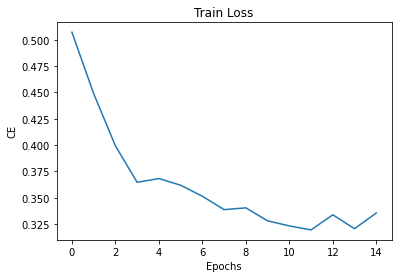

In [15]:
ffnn = FFNNClass(hidden_sizes=[32,32,32],algo = 'Adam',initialization = 'xavier', activation = 'sigmoid', loss = 'cross_entropy')
a,b,c,d = ffnn.fit(x_train,y_OHE_train,x_val,y_OHE_val, epochs=15, eta=0.001,display_loss = True,mini_batch_size=16)

In [16]:
# y_pred_train = ffnn.predict(x_train)
# y_pred_train = np.argmax(y_pred_train,1)

# train_accuracy = accuracy_score(y_train, y_pred_train)
# print("Training accuracy", round(train_accuracy, 3))
# #print(y_pred_train.shape)
# #print(y_train.shape)

In [17]:
y_pred_val = ffnn.predict(x_val)
y_pred_val = np.argmax(y_pred_val,1)
val_accuracy = accuracy_score(y_val, y_pred_val)
print("Testing accuracy", round(val_accuracy, 3))

Testing accuracy 0.862


In [18]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize', 
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'eta': {
            'values': [1e-2,1e-3,1e-4]
        },
        'algo': {
            'values': ['SGD','Momentum','RMS_Prop','NAG','Adam','NAdam']
        },
        'activation': {
            'values': ['sigmoid','tanh','relu']
        },
        'hidden_sizes': {
            'values': [[32,32,32],[64,64,64],[32,64,128],[32,64,128,128]]
        },
        'mini_batch_size':{
            'values':[16,32,64]
        },
        'wt_decay':{
            'values':[0.0,0.5,0.0005]
       },
        'loss':{
            'values':['cross_entropy']
        },
        'initialization':{
            'values':['xavier','random']
        },
    }
}

In [19]:
def train():
    # config_defaults = {
    #     'eta': 0.01,
    #     'epochs': 5,
    #     'algo': 'Adam',
    #     'loss': 'cross_entropy',
    #     'initialization': 'xavier',
    #     'hidden_sizes' : [32,32,32],
    #     'mini_batch_size':16,
    #     'activation': 'sigmoid'
    # }
    wandb.init()
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
  

 
    #  Model training here
    sweep_network = FFNNClass(hidden_sizes=config.hidden_sizes,algo=config.algo,initialization = config.initialization,activation=config.activation,loss=config.loss)
    train_acc,val_acc,train_loss,val_loss = sweep_network.fit(x_train,y_OHE_train,x_val,y_OHE_val, epochs=config.epochs, eta=config.eta,display_loss = True,mini_batch_size=config.mini_batch_size,wt_decay=config.wt_decay)

  

    for zi in range(len(train_acc)):
        print(zi)        
        wandb.log({'train_accuracy':train_acc[zi]})
        wandb.log({'val_accuracy':val_acc[zi]})
        wandb.log({'train_loss':train_loss[zi]}) 
        wandb.log({'val_loss':val_loss[zi]})
        wandb.log({'num_epochs':zi+1})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: ndwnohur
Sweep URL: https://wandb.ai/cs22m043/Assignment1/sweeps/ndwnohur


wandb: Agent Starting Run: 8qjy1acy with config:
wandb: 	activation: sigmoid
wandb: 	algo: RMS_Prop
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_sizes: [64, 64, 64]
wandb: 	initialization: xavier
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 16
wandb: 	wt_decay: 0.5


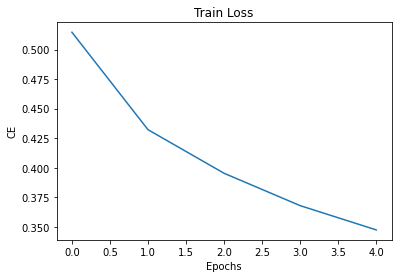

0
1
2
3
4


num_epochs,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
num_epochs,5
train_accuracy,0.87635
train_loss,0.34732
val_accuracy,0.8595
val_loss,0.39966


wandb: Agent Starting Run: 33qv4gpi with config:
wandb: 	activation: sigmoid
wandb: 	algo: RMS_Prop
wandb: 	epochs: 10
wandb: 	eta: 0.001
wandb: 	hidden_sizes: [32, 32, 32]
wandb: 	initialization: xavier
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 32
wandb: 	wt_decay: 0.0005


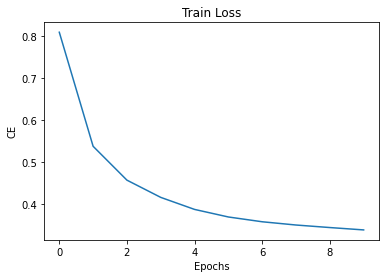

0
1
2
3
4
5
6
7
8
9


num_epochs,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇██████
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
num_epochs,10
train_accuracy,0.88337
train_loss,0.33942
val_accuracy,0.85967
val_loss,0.40788


wandb: Agent Starting Run: zl8uu5ll with config:
wandb: 	activation: tanh
wandb: 	algo: Adam
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_sizes: [32, 64, 128]
wandb: 	initialization: random
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 64
wandb: 	wt_decay: 0


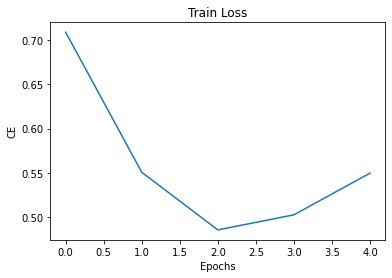

0
1
2
3
4


num_epochs,▁▃▅▆█
train_accuracy,▁▆██▆
train_loss,█▃▁▂▃
val_accuracy,▁▆██▆
val_loss,█▃▁▂▃
num_epochs,5
train_accuracy,0.79819
train_loss,0.54958
val_accuracy,0.78583
val_loss,0.58903


wandb: Agent Starting Run: fzydaybo with config:
wandb: 	activation: relu
wandb: 	algo: NAdam
wandb: 	epochs: 10
wandb: 	eta: 0.001
wandb: 	hidden_sizes: [32, 64, 128, 128]
wandb: 	initialization: xavier
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 32
wandb: 	wt_decay: 0.5


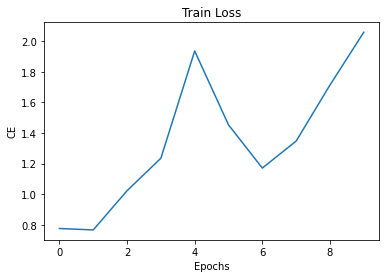

0
1
2
3
4
5
6
7
8
9


num_epochs,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▇▆▅▂▃▅▄▂▁
train_loss,▁▁▂▄▇▅▃▄▆█
val_accuracy,█▇▆▅▂▃▅▄▂▁
val_loss,▁▁▂▃▇▅▃▄▆█
num_epochs,10
train_accuracy,0.16831
train_loss,2.05978
val_accuracy,0.16983
val_loss,2.06082


wandb: Agent Starting Run: gqmco15p with config:
wandb: 	activation: relu
wandb: 	algo: Adam
wandb: 	epochs: 10
wandb: 	eta: 0.001
wandb: 	hidden_sizes: [32, 32, 32]
wandb: 	initialization: random
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 64
wandb: 	wt_decay: 0.5


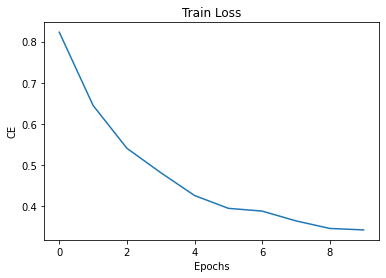

0
1
2
3
4
5
6
7
8
9


num_epochs,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
num_epochs,10
train_accuracy,0.87704
train_loss,0.34228
val_accuracy,0.86133
val_loss,0.41255


wandb: Agent Starting Run: e5mf55u8 with config:
wandb: 	activation: sigmoid
wandb: 	algo: NAG
wandb: 	epochs: 5
wandb: 	eta: 0.0001
wandb: 	hidden_sizes: [32, 64, 128]
wandb: 	initialization: xavier
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 16
wandb: 	wt_decay: 0


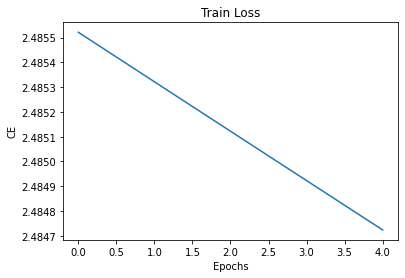

0
1
2
3
4


num_epochs,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▆▄▃▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▄▃▁
num_epochs,5
train_accuracy,0.0995
train_loss,2.48472
val_accuracy,0.1045
val_loss,2.48413


wandb: Agent Starting Run: k8wsyqzo with config:
wandb: 	activation: tanh
wandb: 	algo: NAG
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_sizes: [32, 64, 128]
wandb: 	initialization: xavier
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 32
wandb: 	wt_decay: 0.5


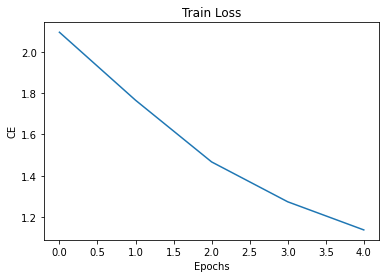

0
1
2
3
4


num_epochs,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▆▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▆▃▂▁
num_epochs,5
train_accuracy,0.63183
train_loss,1.13813
val_accuracy,0.624
val_loss,1.14657


wandb: Agent Starting Run: q1ty5zu4 with config:
wandb: 	activation: tanh
wandb: 	algo: NAdam
wandb: 	epochs: 10
wandb: 	eta: 0.001
wandb: 	hidden_sizes: [32, 64, 128]
wandb: 	initialization: xavier
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 16
wandb: 	wt_decay: 0.0005


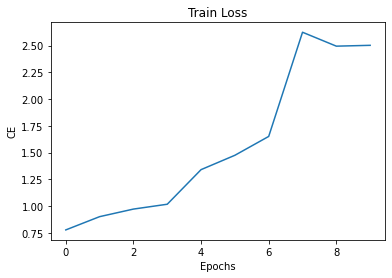

0
1
2
3
4
5
6
7
8
9


num_epochs,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▇▇▇▅▄▄▁▁▁
train_loss,▁▁▂▂▃▄▄███
val_accuracy,█▇▇▇▅▄▄▁▁▁
val_loss,▁▁▂▂▃▄▄█▇▇
num_epochs,10
train_accuracy,0.09993
train_loss,2.50193
val_accuracy,0.10067
val_loss,2.5075


wandb: Agent Starting Run: k1ljltfh with config:
wandb: 	activation: tanh
wandb: 	algo: NAG
wandb: 	epochs: 10
wandb: 	eta: 0.0001
wandb: 	hidden_sizes: [32, 64, 128]
wandb: 	initialization: xavier
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 64
wandb: 	wt_decay: 0


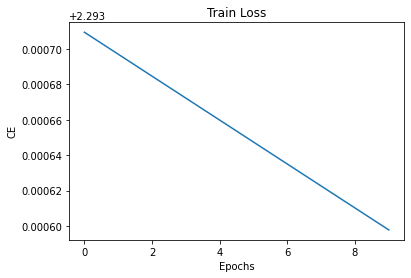

0
1
2
3
4
5
6
7
8
9


num_epochs,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▂▃▄▄▅█
train_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▁▁▁███▁▁▁
val_loss,█▇▆▆▅▄▃▃▂▁
num_epochs,10
train_accuracy,0.15737
train_loss,2.2936
val_accuracy,0.16033
val_loss,2.29353


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j7o4fz9w with config:
wandb: 	activation: sigmoid
wandb: 	algo: NAdam
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_sizes: [32, 32, 32]
wandb: 	initialization: random
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 32
wandb: 	wt_decay: 0


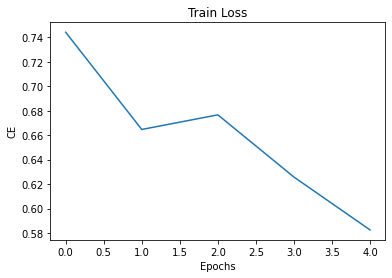

0
1
2
3
4


num_epochs,▁▃▅▆█
train_accuracy,▁▄▅▆█
train_loss,█▅▅▃▁
val_accuracy,▁▄▄▅█
val_loss,█▅▆▄▁
num_epochs,5
train_accuracy,0.80585
train_loss,0.58257
val_accuracy,0.79283
val_loss,0.60838


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 59ariqiv with config:
wandb: 	activation: tanh
wandb: 	algo: RMS_Prop
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_sizes: [32, 64, 128]
wandb: 	initialization: xavier
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 64
wandb: 	wt_decay: 0


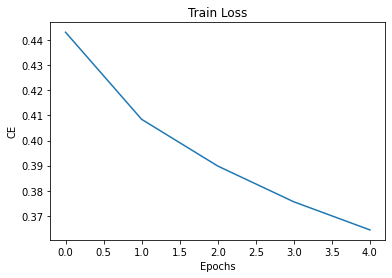

0
1
2
3
4


num_epochs,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
num_epochs,5
train_accuracy,0.8693
train_loss,0.36437
val_accuracy,0.85167
val_loss,0.41758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mceabqnf with config:
wandb: 	activation: sigmoid
wandb: 	algo: SGD
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_sizes: [64, 64, 64]
wandb: 	initialization: random
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 64
wandb: 	wt_decay: 0


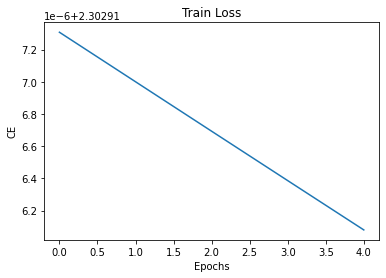

0
1
2
3
4


num_epochs,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▇▅▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▆▃▁
num_epochs,5
train_accuracy,0.0995
train_loss,2.30292
val_accuracy,0.1045
val_loss,2.30265


wandb: Agent Starting Run: lxo0cqas with config:
wandb: 	activation: relu
wandb: 	algo: NAG
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_sizes: [64, 64, 64]
wandb: 	initialization: xavier
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 32
wandb: 	wt_decay: 0


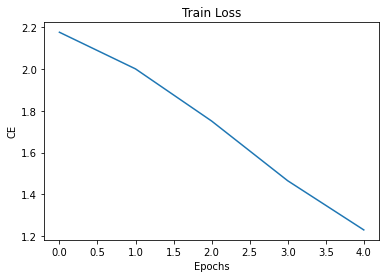

0
1
2
3
4


num_epochs,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▇▅▃▁
val_accuracy,▁▄▆▇█
val_loss,█▇▅▃▁
num_epochs,5
train_accuracy,0.58041
train_loss,1.22984
val_accuracy,0.57367
val_loss,1.24476


wandb: Agent Starting Run: axntb0hc with config:
wandb: 	activation: sigmoid
wandb: 	algo: Momentum
wandb: 	epochs: 10
wandb: 	eta: 0.001
wandb: 	hidden_sizes: [64, 64, 64]
wandb: 	initialization: random
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 32
wandb: 	wt_decay: 0


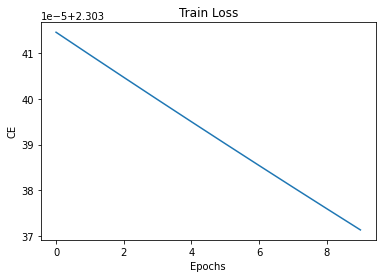

0
1
2
3
4
5
6
7
8
9


num_epochs,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▃▃▂▁
num_epochs,10
train_accuracy,0.10031
train_loss,2.30337
val_accuracy,0.09717
val_loss,2.30309


wandb: Agent Starting Run: fsli3954 with config:
wandb: 	activation: relu
wandb: 	algo: Adam
wandb: 	epochs: 10
wandb: 	eta: 0.001
wandb: 	hidden_sizes: [32, 32, 32]
wandb: 	initialization: xavier
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 32
wandb: 	wt_decay: 0.5


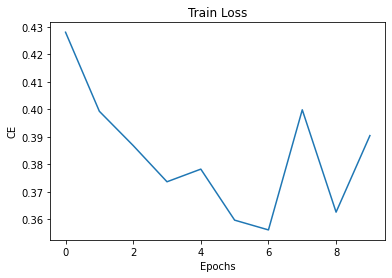

0
1
2
3
4
5
6
7
8
9


num_epochs,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▆▅█▇▅█▆
train_loss,█▅▄▃▃▁▁▅▂▄
val_accuracy,▁▅▄▇▅██▃█▅
val_loss,▄▃▂▂▃▃▁█▆█
num_epochs,10
train_accuracy,0.86535
train_loss,0.39043
val_accuracy,0.84583
val_loss,0.49443


wandb: Agent Starting Run: pv5n0pn7 with config:
wandb: 	activation: relu
wandb: 	algo: NAdam
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_sizes: [32, 64, 128, 128]
wandb: 	initialization: random
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 32
wandb: 	wt_decay: 0.5


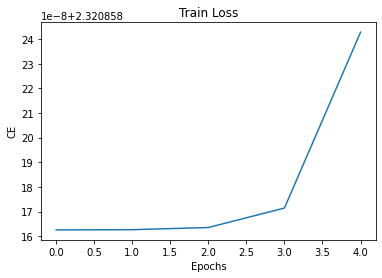

0
1
2
3
4


num_epochs,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁█
num_epochs,5
train_accuracy,0.10002
train_loss,2.32086
val_accuracy,0.09983
val_loss,2.32142


wandb: Agent Starting Run: ljuf8o69 with config:
wandb: 	activation: sigmoid
wandb: 	algo: SGD
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_sizes: [32, 64, 128]
wandb: 	initialization: xavier
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 16
wandb: 	wt_decay: 0.5


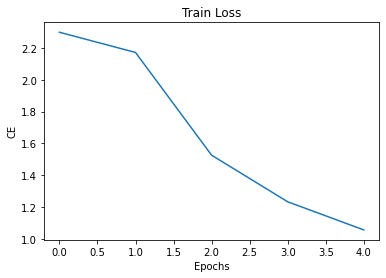

0
1
2
3
4


num_epochs,▁▃▅▆█
train_accuracy,▁▃▅▇█
train_loss,█▇▄▂▁
val_accuracy,▁▃▅▇█
val_loss,█▇▄▂▁
num_epochs,5
train_accuracy,0.59796
train_loss,1.05552
val_accuracy,0.59017
val_loss,1.06571


wandb: Agent Starting Run: afg5nobc with config:
wandb: 	activation: sigmoid
wandb: 	algo: RMS_Prop
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_sizes: [32, 64, 128]
wandb: 	initialization: random
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 16
wandb: 	wt_decay: 0.0005


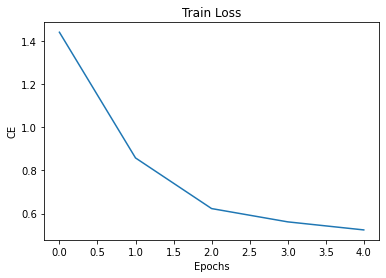

0
1
2
3
4


num_epochs,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
num_epochs,5
train_accuracy,0.82417
train_loss,0.5243
val_accuracy,0.813
val_loss,0.58653


wandb: Agent Starting Run: vem7iqw2 with config:
wandb: 	activation: tanh
wandb: 	algo: RMS_Prop
wandb: 	epochs: 10
wandb: 	eta: 0.0001
wandb: 	hidden_sizes: [32, 64, 128, 128]
wandb: 	initialization: xavier
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 32
wandb: 	wt_decay: 0.5


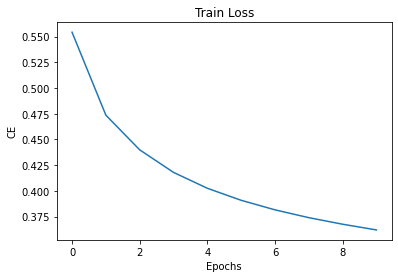

0
1
2
3
4
5
6
7
8
9


num_epochs,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
num_epochs,10
train_accuracy,0.87076
train_loss,0.36202
val_accuracy,0.85983
val_loss,0.40728


wandb: Agent Starting Run: sexcx7st with config:
wandb: 	activation: sigmoid
wandb: 	algo: NAG
wandb: 	epochs: 10
wandb: 	eta: 0.0001
wandb: 	hidden_sizes: [64, 64, 64]
wandb: 	initialization: random
wandb: 	loss: cross_entropy
wandb: 	mini_batch_size: 16
wandb: 	wt_decay: 0.0005


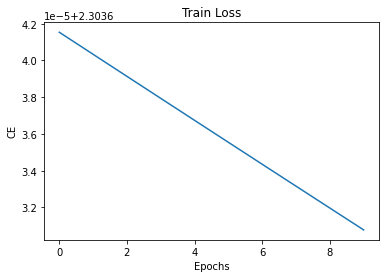

0
1
2
3
4
5
6
7
8
9


num_epochs,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▄▃▂▂▁
num_epochs,10
train_accuracy,0.0995
train_loss,2.30363
val_accuracy,0.1045
val_loss,2.30322


Error in callback <function _WandbInit._pause_backend at 0x7fa35f929dc0> (for post_run_cell):


BrokenPipeError: ignored

In [20]:
#wandb.init()
id = wandb.sweep(sweep_config, project="Assignment1", entity ="cs22m043")
wandb.agent(id, function=train, count=20)

In [21]:
# sweep_network = FFNNClass([32, 64, 128],"Adam","xavier","sigmoid","cross_entropy")
# train_acc,val_acc,train_loss,val_loss = sweep_network.fit(x_train,y_OHE_train,x_val,y_OHE_val,5,0.001,64)

Error in callback <function _WandbInit._resume_backend at 0x7fa35f9299d0> (for pre_run_cell):


BrokenPipeError: ignored

Error in callback <function _WandbInit._pause_backend at 0x7fa35f929dc0> (for post_run_cell):


BrokenPipeError: ignored

Error in callback <function _WandbInit._pause_backend at 0x7fa35f929dc0> (for post_run_cell):


BrokenPipeError: ignored